In [26]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
import hashlib
import community as community_louvain

In [27]:
# importing the data_set
data_df = pd.read_csv('../../../data/processed/fully_integrated_data.csv')
data_df.columns

Index(['raceId', 'season', 'raceNumber', 'circuitId', 'prixName', 'raceDate',
       'driverId', 'constructorId', 'driverStartGridPos', 'driverFinalGridPos',
       'driverFinalRank', 'driverRacePoints', 'driverLapCount',
       'driverFatestLapNumber', 'driverFastestLapTime',
       'driverFastestLapSpeed', 'constructorName', 'constructorNationality',
       'constructorChampionshipStandingPoints',
       'constructorChampionshipStandingPosition',
       'constructorChampionshipStandingWins', 'constructorRacePoints',
       'driverDateOfBirth', 'driverNationality',
       'driverChampionshipStandingPoints',
       'driverChampionshipStandingPosition', 'driverChampionshipStandingWins',
       'circuitName', 'circuitLocation', 'circuitCountry', 'lat', 'lng', 'alt',
       'driverRaceResultStatus', 'driverName', 'driverAge', 'race_time'],
      dtype='object')

Top 10 drivers with most transitions:
DriverID: 427, Driver: Maurice Trintignant, Transitions: 18
DriverID: 475, Driver: Stirling Moss, Transitions: 16
DriverID: 197, Driver: Jean-Pierre Jarier, Transitions: 15
DriverID: 278, Driver: Chris Amon, Transitions: 14
DriverID: 347, Driver: Jo Bonnier, Transitions: 13
DriverID: 364, Driver: Dan Gurney, Transitions: 12
DriverID: 456, Driver: Roy Salvadori, Transitions: 12
DriverID: 110, Driver: Andrea de Cesaris, Transitions: 11
DriverID: 235, Driver: Jacky Ickx, Transitions: 11
DriverID: 140, Driver: Stefan Johansson, Transitions: 10


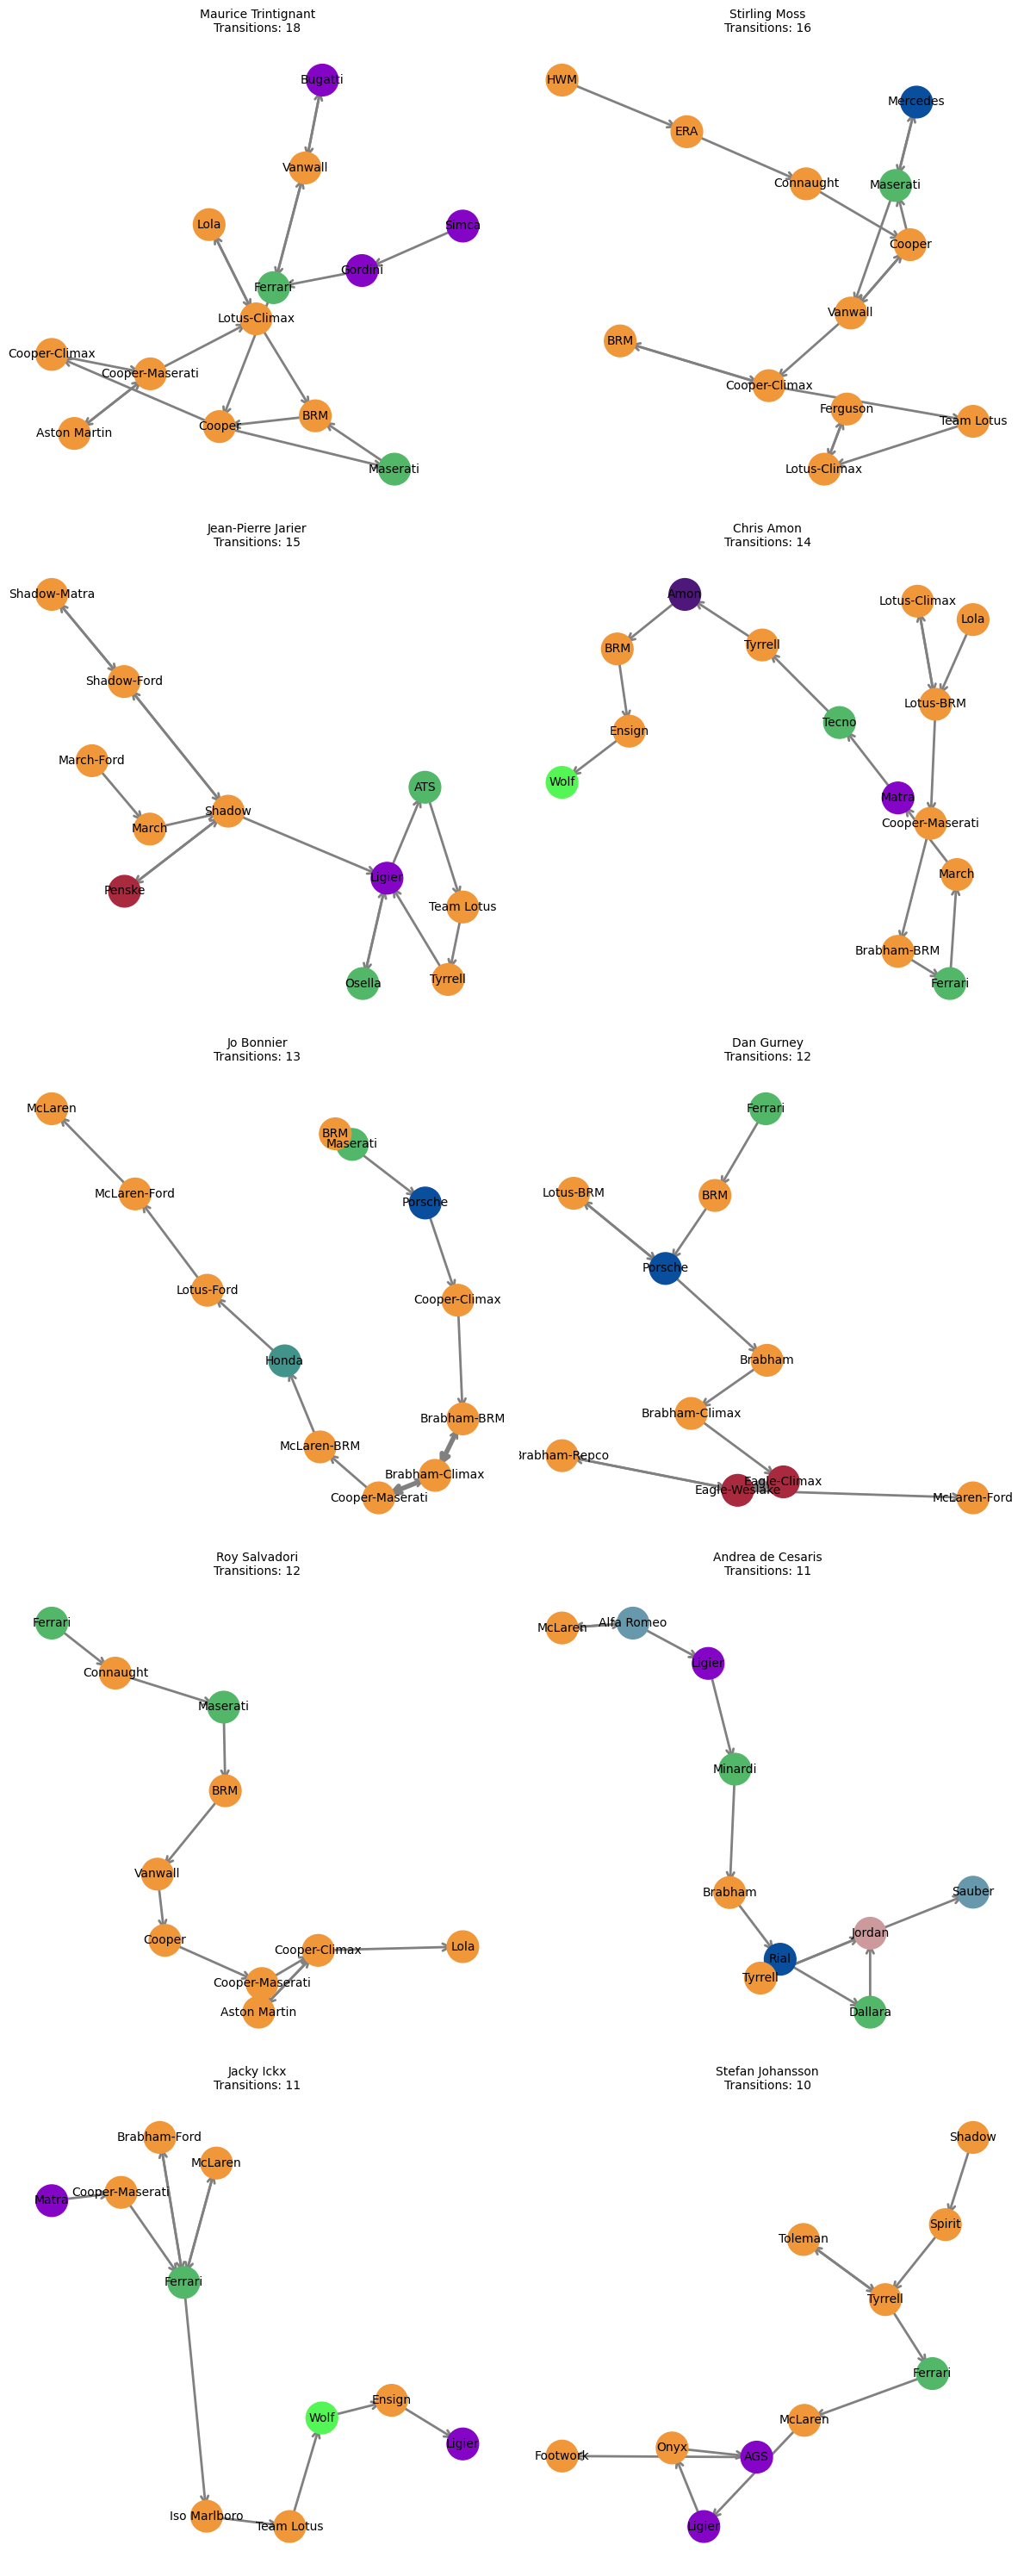

In [28]:

df_sorted = data_df.sort_values(by=['driverId', 'season'])

# Dictionary to hold each driver's career graph
driver_graphs = {}

# Loop over each driver
for driver, group in df_sorted.groupby('driverId'):
    group = group.sort_values(by='season')
    # Skip drivers who stayed with only one team (no transitions)
    if group['constructorId'].nunique() <= 1:
        continue
    
    # Build the team sequence for the driver
    team_sequence = group[['constructorId', 'constructorName', 'constructorNationality', 'season']].to_dict(orient='records')
    
    transitions = []
    # Record transitions only when the team changes
    for i in range(1, len(team_sequence)):
        prev_team = team_sequence[i-1]
        curr_team = team_sequence[i]
        if prev_team['constructorId'] != curr_team['constructorId']:
            transitions.append((prev_team['constructorName'], curr_team['constructorName']))
    
    # Skip if no transitions found
    if not transitions:
        continue
    
    # Create a DataFrame of transitions and aggregate counts
    trans_df = pd.DataFrame(transitions, columns=['source', 'target'])
    edge_counts = trans_df.groupby(['source', 'target']).size().reset_index(name='weight')
    
    # Create a directed graph for the driver
    G = nx.DiGraph()
    # Add nodes: use constructorName and store nationality as an attribute
    for rec in team_sequence:
        team_name = rec['constructorName']
        G.add_node(team_name, nationality=rec.get('constructorNationality', None))
    
    # Add edges with weights from transitions
    for idx, row in edge_counts.iterrows():
        G.add_edge(row['source'], row['target'], weight=row['weight'])
    
    driver_graphs[driver] = {
        'driverName': group['driverName'].iloc[0],
        'graph': G
    }

# ----- Select Top 10 Drivers with the Most Team Changes -----
# Count transitions (edges) for each driver
driver_transition_counts = {driver: info['graph'].number_of_edges() for driver, info in driver_graphs.items()}
# Get top 10 drivers sorted by the number of transitions (descending)
top_10_drivers = sorted(driver_transition_counts.items(), key=lambda x: x[1], reverse=True)[:10]
top_10_driver_ids = [item[0] for item in top_10_drivers]

print("Top 10 drivers with most transitions:")
for driver in top_10_driver_ids:
    print(f"DriverID: {driver}, Driver: {driver_graphs[driver]['driverName']}, Transitions: {driver_graphs[driver]['graph'].number_of_edges()}")

# ----- Plot the Network Graphs for Top 10 Drivers -----
num_graphs = len(top_10_driver_ids)
cols = 2  # Number of subplots per row
rows = (num_graphs // cols) + (1 if num_graphs % cols != 0 else 0)
plt.figure(figsize=(cols * 6, rows * 6))

i = 1
for driver in top_10_driver_ids:
    info = driver_graphs[driver]
    G = info['graph']
    driver_name = info['driverName']
    
    plt.subplot(rows, cols, i)
    i += 1
    pos = nx.spring_layout(G, seed=42)
    
    # Determine node colors based on constructor nationality
    node_colors = []
    for node, data in G.nodes(data=True):
        nat = data.get('nationality')
        if nat is None:
            node_colors.append('lightgray')
        else:
            # Generate a reproducible random color from the nationality string
            h = int(hashlib.sha256(nat.encode('utf-8')).hexdigest(), 16)
            np.random.seed(h % (2**32))
            color = np.random.rand(3,)  # RGB values between 0 and 1
            node_colors.append(color)
    
    # Set edge thickness proportional to the weight
    edge_widths = [G[u][v]['weight'] * 2 for u, v in G.edges()]
    
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=700)
    nx.draw_networkx_edges(G, pos, width=edge_widths, arrowstyle='->', arrowsize=15, edge_color='gray')
    nx.draw_networkx_labels(G, pos, font_size=10)
    
    plt.title(f"{driver_name}\nTransitions: {G.number_of_edges()}", fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()


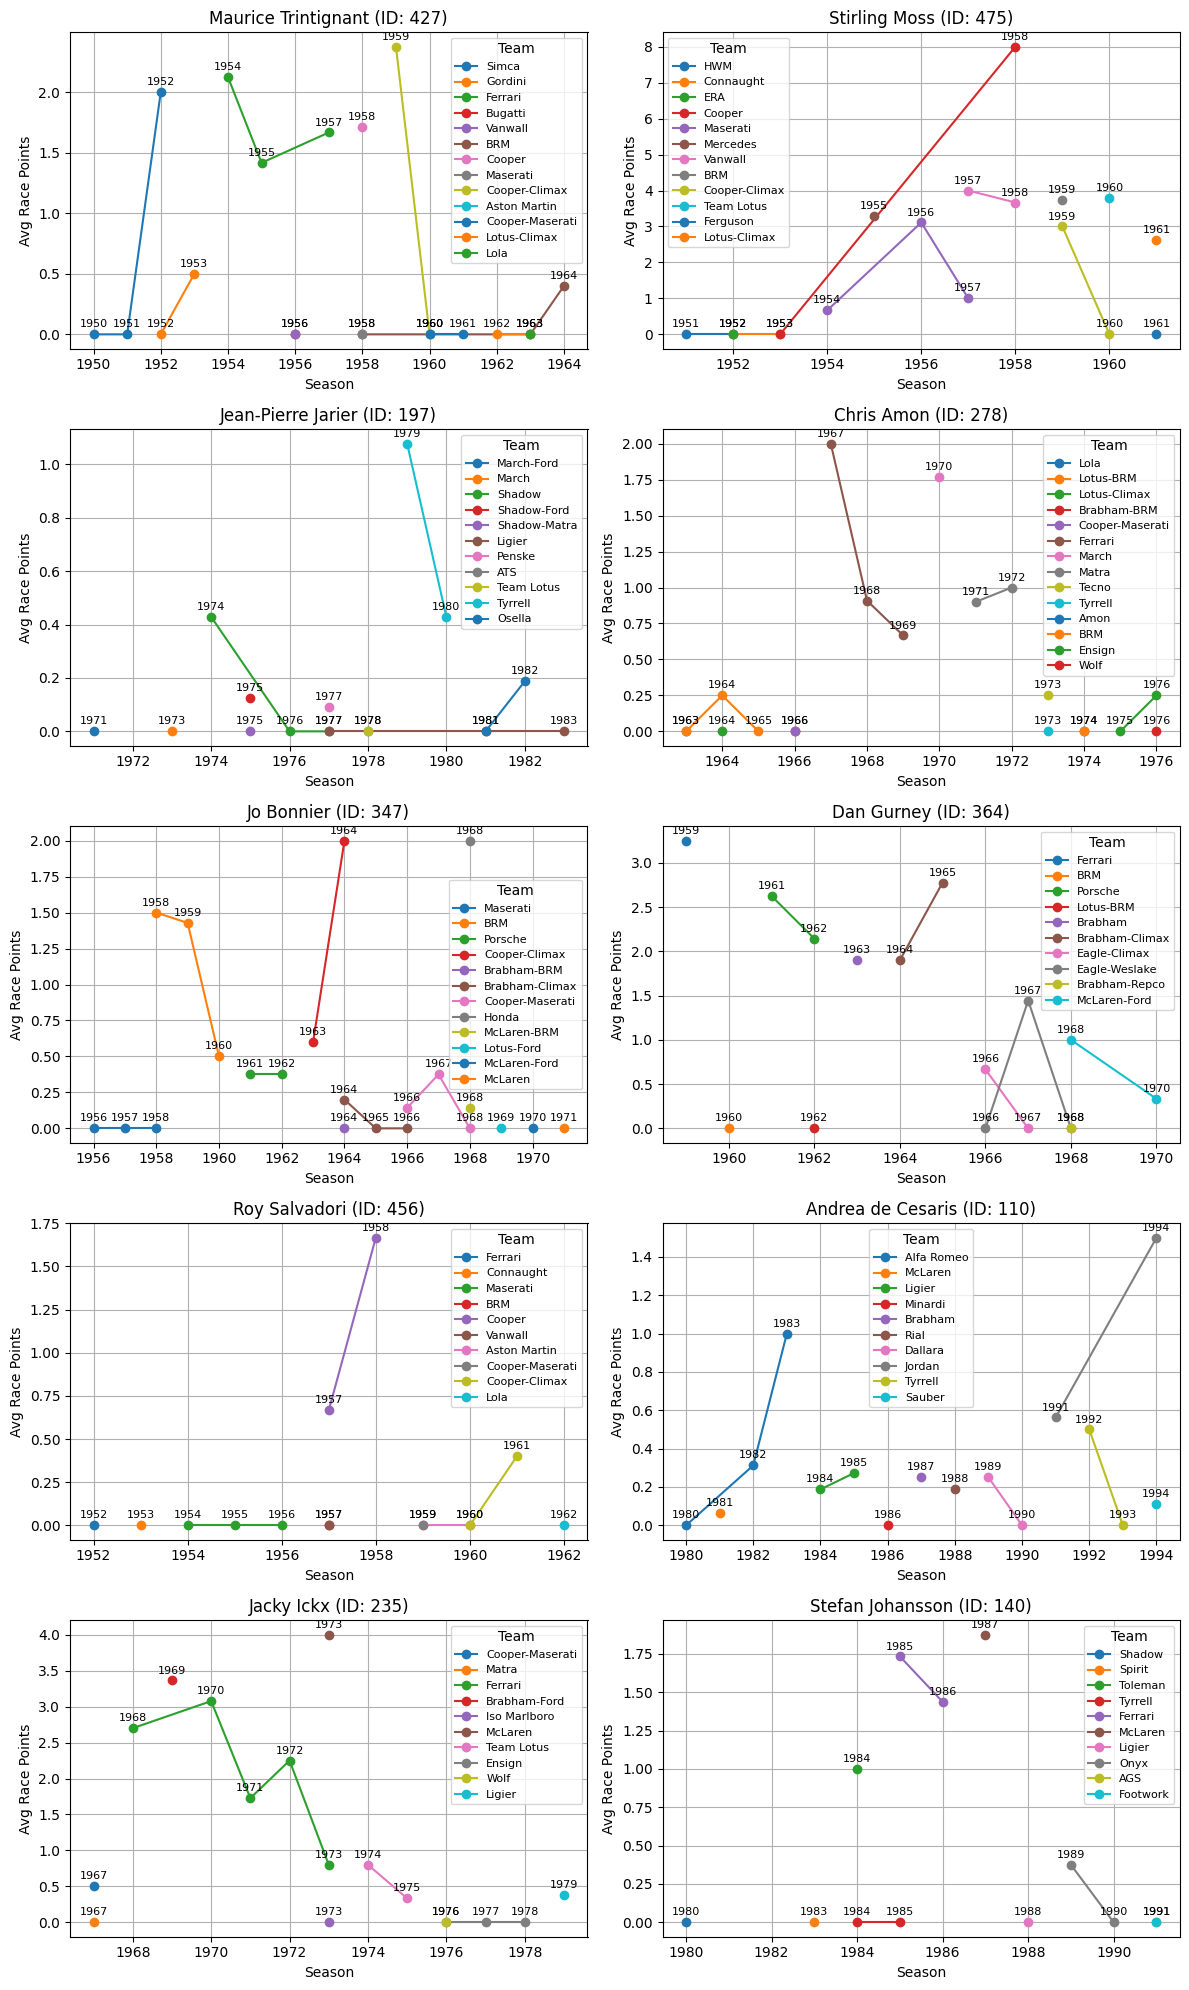

In [29]:
top_drivers_data = {}
for driver in top_10_driver_ids:
    # Filter data for the driver
    driver_data = df_sorted[df_sorted['driverId'] == driver]
    # Group by season and constructorName, calculating the average driverRacePoints per season
    # (Assuming a driver may have multiple races in a season; we average over the season)
    career_data = driver_data.groupby(['season', 'constructorName']).agg({
        'driverRacePoints': 'mean',
        'driverName': 'first'  # To keep the driver's name
    }).reset_index()
    top_drivers_data[driver] = career_data

# Plotting: Create subplots for the top 10 drivers
n = len(top_10_driver_ids)
cols = 2
rows = (n + 1) // 2  # Two plots per row
plt.figure(figsize=(cols * 6, rows * 4))

# Loop through each top driver and plot their career data
for idx, driver in enumerate(top_10_driver_ids):
    data_driver = top_drivers_data[driver]
    # Get driver name for title
    driver_name = data_driver['driverName'].iloc[0]
    
    ax = plt.subplot(rows, cols, idx+1)
    
    # For each team (constructor), plot a line for the seasons the driver was with that team.
    for constructor in data_driver['constructorName'].unique():
        subset = data_driver[data_driver['constructorName'] == constructor]
        # Plot the line with markers; label the line with the team name.
        ax.plot(subset['season'], subset['driverRacePoints'], marker='o', linestyle='-',
                label=constructor)
        
        # Optionally annotate each point with the season (if desired)
        for _, row in subset.iterrows():
            ax.annotate(f"{int(row['season'])}", (row['season'], row['driverRacePoints']),
                        textcoords="offset points", xytext=(0,5), ha='center', fontsize=8)
    
    ax.set_title(f"{driver_name} (ID: {driver})")
    ax.set_xlabel("Season")
    ax.set_ylabel("Avg Race Points")
    ax.legend(title="Team", fontsize=8, loc="best")
    ax.grid(True)

plt.tight_layout()
plt.show()

##### Dynamic or Temporal Analysis

Sample transitions:
   season    source      target target_nationality
0    2013   McLaren    Mercedes             German
1    2001     Prost      Sauber              Swiss
2    2004    Sauber      Jordan              Irish
3    2005    Jordan    Williams            British
4    2006  Williams  BMW Sauber             German
Unique seasons: [np.int64(1950), np.int64(1951), np.int64(1952), np.int64(1953), np.int64(1954), np.int64(1955), np.int64(1956), np.int64(1957), np.int64(1958), np.int64(1959), np.int64(1960), np.int64(1961), np.int64(1962), np.int64(1963), np.int64(1964), np.int64(1965), np.int64(1966), np.int64(1967), np.int64(1968), np.int64(1969), np.int64(1970), np.int64(1971), np.int64(1972), np.int64(1973), np.int64(1974), np.int64(1975), np.int64(1976), np.int64(1977), np.int64(1978), np.int64(1979), np.int64(1980), np.int64(1981), np.int64(1982), np.int64(1983), np.int64(1984), np.int64(1985), np.int64(1986), np.int64(1987), np.int64(1988), np.int64(1989), np.int64(1990), n

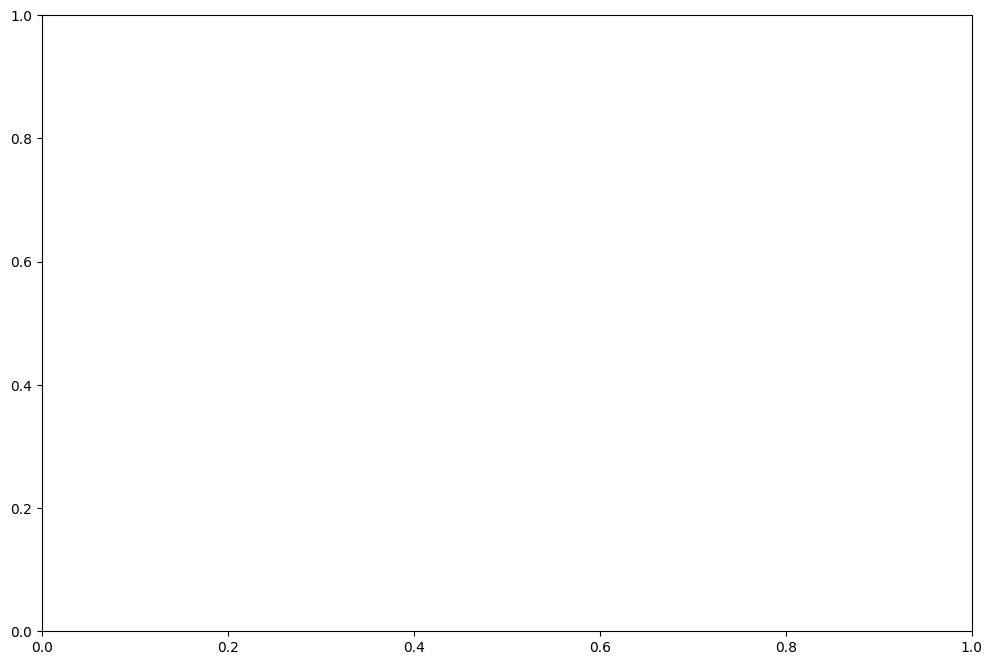

In [30]:
transitions = []
for driver, group in df_sorted.groupby('driverId'):
    group = group.sort_values(by='season')
    # Build a list of team records for this driver.
    team_seq = group[['season', 'constructorId', 'constructorName', 'constructorNationality']].to_dict('records')
    for i in range(1, len(team_seq)):
        prev_team = team_seq[i-1]
        curr_team = team_seq[i]
        if prev_team['constructorId'] != curr_team['constructorId']:
            transitions.append((curr_team['season'],
                                prev_team['constructorName'],
                                curr_team['constructorName'],
                                curr_team.get('constructorNationality', None)))
            

            
# Convert transitions list to a DataFrame.
transitions_df = pd.DataFrame(transitions, columns=['season', 'source', 'target', 'target_nationality'])
print("Sample transitions:")
print(transitions_df.head())
# ----- Step 1: Data Preparation (Assuming transitions_df exists) -----
# Convert season to numeric if not already
transitions_df['season'] = pd.to_numeric(transitions_df['season'], errors='coerce')

# Get unique seasons from the transitions (or the full dataset)
seasons = sorted(transitions_df['season'].dropna().unique())
print("Unique seasons:", seasons)

def get_cumulative_graph(upto_season, transitions_df):
    """
    Build a cumulative directed graph of driver transitions up to a given season.
    """
    G = nx.DiGraph()
    trans_filtered = transitions_df[transitions_df['season'] <= upto_season]
    for idx, row in trans_filtered.iterrows():
        source, target = row['source'], row['target']
        if G.has_edge(source, target):
            G[source][target]['weight'] += 1
        else:
            G.add_edge(source, target, weight=1)
    return G


# Build final cumulative graph to compute a fixed layout
final_graph = get_cumulative_graph(seasons[-1], transitions_df)
pos = nx.spring_layout(final_graph, seed=42)  # fixed layout for consistency

# ----- Step 2: Animate the Cumulative Network Over Seasons -----
fig, ax = plt.subplots(figsize=(12, 8))

def update(current_season):
    ax.clear()
    print(f"Updating frame for season: {current_season}")  # Debug print to ensure update is called
    G_current = get_cumulative_graph(current_season, transitions_df)
    
    # Compute degree centrality for nodes in G_current
    deg_cent = nx.degree_centrality(G_current)
    node_sizes = [500 + 3000 * deg_cent.get(node, 0) for node in G_current.nodes()]
    node_colors = [deg_cent.get(node, 0) for node in G_current.nodes()]
    
    # Draw nodes with fixed positions
    nx.draw_networkx_nodes(G_current, pos, ax=ax, node_size=node_sizes, 
                           node_color=node_colors, cmap=plt.cm.viridis)
    
    # Draw edges with width proportional to weight
    edge_widths = [G_current[u][v]['weight'] for u, v in G_current.edges()]
    nx.draw_networkx_edges(G_current, pos, ax=ax, arrowstyle='->', arrowsize=12,
                           width=edge_widths, edge_color='gray')
    
    # Draw labels (team names)
    nx.draw_networkx_labels(G_current, pos, ax=ax, font_size=9)
    
    ax.set_title(f"Cumulative Driver Transitions up to Season: {current_season}")
    ax.axis('off')
    
    # Add a colorbar for centrality if nodes exist
    if node_colors:
        sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(node_colors), vmax=max(node_colors)))
        sm.set_array([])
        plt.colorbar(sm, ax=ax, label="Degree Centrality")

# Use the season values directly as frames
anim = animation.FuncAnimation(fig, update, frames=seasons, interval=1500, repeat=True)

plt.show()


##### Community Detection

Detected Communities:
Community 0: ['McLaren', 'Williams', 'BMW Sauber', 'Renault', 'Alpine F1 Team', 'Aston Martin', 'Lotus', 'Caterham', 'Lotus F1', 'Virgin', 'Marussia', 'Red Bull', 'Force India', 'Brawn', 'Toro Rosso', 'HRT', 'Brabham', 'ATS', 'Lambo', 'Shadow', 'Ensign', 'Theodore', 'Brabham-Alfa Romeo', 'Brabham-Ford', 'Haas F1 Team', 'Hesketh', 'Martini', 'Surtees', 'Iso Marlboro', 'Wolf', 'Fittipaldi', 'Embassy Hill', 'Penske', 'Shadow-Ford', 'Shadow-Matra', 'Token', 'LEC', 'Apollon', 'Kojima', 'Tecno', 'McLaren-Ford', 'De Tomaso', 'Bellasi', 'McLaren-Serenissima', 'Racing Point', 'AlphaTauri', 'RB F1 Team', 'Manor Marussia']
Community 1: ['Mercedes', 'Ferrari', 'Alfa Romeo', 'Maserati', 'Cooper-Castellotti', 'Cooper', 'Fry', 'Simca', 'Gordini', 'Vanwall', 'Bugatti', 'Talbot-Lago', 'Connaught', 'Veritas', 'HWM', 'ERA', 'JBW', 'OSCA', 'Tec-Mec', 'Cooper-OSCA', 'Arzani-Volpini', 'Lancia', 'Frazer Nash', 'Alta', 'Klenk', 'Milano', 'AFM', 'BMW']
Community 5: ['Prost', 'Sauber', 'Jo

/tmp/ipykernel_930171/2375685796.py:74: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_communities)  # or 'tab10', 'viridis', etc.


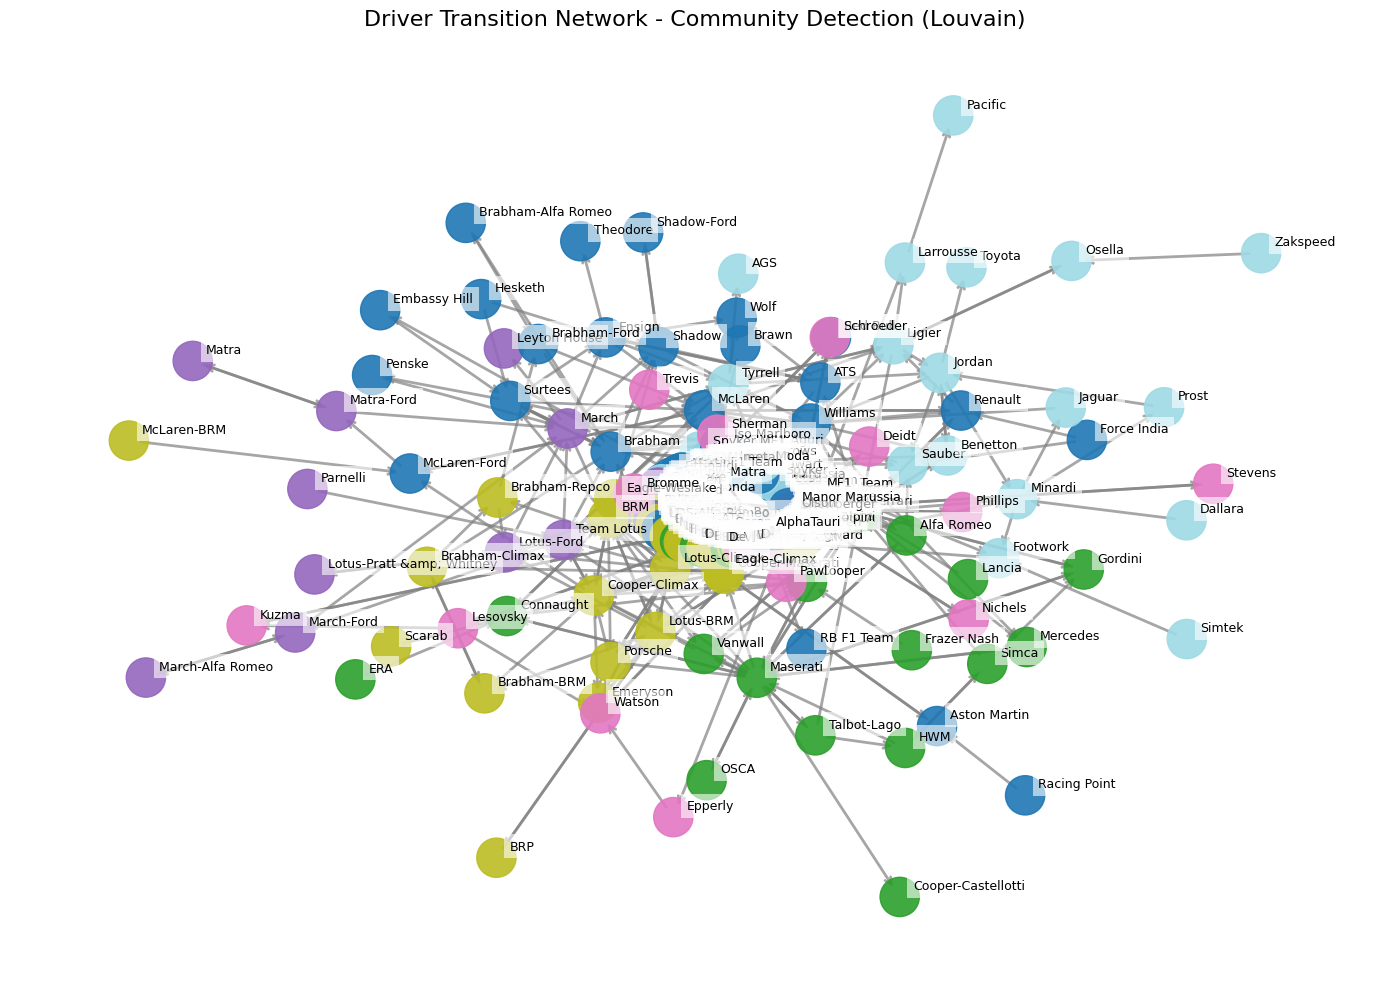

In [31]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import community as community_louvain  # pip install python-louvain

# -----------------------------------------------------------------------------
# 1. BUILDING THE FINAL CUMULATIVE GRAPH (IF NOT ALREADY BUILT)
# -----------------------------------------------------------------------------
# Suppose you already have 'transitions_df' with columns:
# ['season', 'source', 'target', 'target_nationality'] representing driver transitions.
# And 'seasons' is a sorted list of all seasons.

def get_cumulative_graph(upto_season, transitions_df):
    """
    Build a cumulative directed graph of driver transitions up to a given season.
    Edges are weighted by the number of transitions between teams.
    """
    G = nx.DiGraph()
    trans_filtered = transitions_df[transitions_df['season'] <= upto_season]
    for idx, row in trans_filtered.iterrows():
        source, target = row['source'], row['target']
        if G.has_edge(source, target):
            G[source][target]['weight'] += 1
        else:
            G.add_edge(source, target, weight=1)
    return G

# Let's say we want the final graph for the last season in 'seasons'
# (or you could pick the max season in transitions_df)
last_season = max(transitions_df['season'])
final_graph = get_cumulative_graph(last_season, transitions_df)

# -----------------------------------------------------------------------------
# 2. COMMUNITY DETECTION (LOUVAIN)
# -----------------------------------------------------------------------------
# Convert final_graph to undirected for Louvain
G_undirected = final_graph.to_undirected()

# Apply Louvain method
partition = community_louvain.best_partition(G_undirected)

# Print the detected communities
communities = {}
for node, comm in partition.items():
    communities.setdefault(comm, []).append(node)

print("Detected Communities:")
for comm_id, nodes_list in communities.items():
    print(f"Community {comm_id}: {nodes_list}")

# Store community ID in the directed graph as a node attribute (optional)
nx.set_node_attributes(final_graph, partition, 'community')

# -----------------------------------------------------------------------------
# 3. EDGE FILTERING (REMOVE LOW-WEIGHT EDGES TO REDUCE CLUTTER)
# -----------------------------------------------------------------------------
threshold = 2  # remove edges with weight < 2
edges_to_remove = []
for (u, v, data) in final_graph.edges(data=True):
    if data['weight'] < threshold:
        edges_to_remove.append((u, v))

final_graph.remove_edges_from(edges_to_remove)

# -----------------------------------------------------------------------------
# 4. LAYOUT & PLOTTING
# -----------------------------------------------------------------------------
# (a) Compute the Kamada–Kawai layout for a cleaner distribution
pos = nx.kamada_kawai_layout(final_graph)

# (b) Prepare a color map for communities
num_communities = len(communities)
cmap = cm.get_cmap('tab20', num_communities)  # or 'tab10', 'viridis', etc.

# Map each node to a color based on its community
node_colors = []
for node in final_graph.nodes():
    comm_id = final_graph.nodes[node].get('community', 0)
    node_colors.append(cmap(comm_id))

# (c) Plot
plt.figure(figsize=(14, 10))

# Draw nodes
nx.draw_networkx_nodes(
    final_graph, pos,
    node_size=800,
    node_color=node_colors,
    alpha=0.9
)

# Draw edges with arrowstyle
nx.draw_networkx_edges(
    final_graph, pos,
    arrowstyle='->', arrowsize=12,
    width=2, edge_color='gray', alpha=0.7
)

# (d) Offset labels to reduce overlap
for node, (x, y) in pos.items():
    plt.text(x + 0.02, y + 0.02, node,
             fontsize=9, bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

plt.title("Driver Transition Network - Community Detection (Louvain)", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()


### **Inference from the Community Detection Plot**  

This network visualization represents **Formula 1 teams** as nodes, with edges indicating driver transitions between them. The **Louvain community detection** algorithm was applied to identify clusters of teams that frequently exchange drivers. Each detected community is colored differently.

#### **Observations:**
1. **Large Central Cluster (Purple & Yellow)**
   - The **largest clusters** in the center suggest historically dominant teams with frequent driver exchanges.  
   - These likely include **Ferrari, McLaren, Williams, Renault, and Red Bull**, which have been active in F1 for decades.
   - The dense connectivity indicates that many drivers transition within this core group.

2. **Peripheral, Less Connected Teams**
   - The **isolated groups** on the outskirts (e.g., the **pink and blue clusters**) might represent:
     - Smaller or short-lived teams (e.g., Andrea Moda, Life, Simtek).
     - Early-era F1 teams that no longer exist.
   - These communities likely had fewer driver transitions, contributing to their isolation.

3. **Modern F1 Teams in Blue & Green**
   - The **blue clusters** may represent **modern F1 teams** like **Mercedes, Red Bull, Haas, and Alpine**.
   - If you look at the **top-right** or **bottom-right clusters**, they could contain newer teams like **Toro Rosso, Virgin, Marussia, and Haas**, which mostly exchange drivers within a specific era.


